<a href="https://colab.research.google.com/github/alexphil12/Energy-forcasting-UDLA/blob/main/Optimization_of_hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import copy as cp
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import Dropout


In [ ]:
df = pd.read_csv('/content/df_cov_continu_1_1.txt', index_col=0, parse_dates=True,sep=',')
N=len(list(df.iloc[:,3]))
df_train=df.iloc[0:round(N*0.8),:]
df_test=df.iloc[round(N*0.8):N,:]

In [ ]:
mesure=["Fecha","Hora"];
mesure.append("Voltaje_(R)_[V]")	
mesure.append("Voltaje_(S)_[V]")	
mesure.append("Voltaje_(T)_[V]")	
mesure.append("Voltaje_(RS)_[V]")	
mesure.append("Voltaje_(ST)_[V]")	
mesure.append("Voltaje_(TR)_[V]")	
mesure.append("Corriente_R_[A]")	
mesure.append("Corriente_S_[A]")	
mesure.append("Corriente_T_[A]")	
mesure.append("Potencia_R_[VA]")	
mesure.append("Potencia_S_[VA]")	
mesure.append("Potencia_T_[VA]")	
mesure.append("Potencia_R_[W]")	
mesure.append("Potencia_S_[W]")	
mesure.append("Potencia_T_[W]")	
mesure.append("Potencia_R_[VAR]")	
mesure.append("Potencia_S_[VAR]")	
mesure.append("Potencia_T_[VAR]")	
mesure.append("Corriente_N_[A]")	
mesure.append("Frecuencia_[Hz]")	
mesure.append("not_sure_1")	
mesure.append("not_sure_2")	
mesure.append("not_sure_3")	
mesure.append("Potencia_3F_[KVA]")	
mesure.append("Potencia_3F_[W]")	
mesure.append("Potencia_3F_[VAR]")	
mesure.append("Factor de Potencia")

In [ ]:
df_train.drop(columns=[mesure[0],mesure[1]],inplace=True)
df_test.drop(columns=[mesure[0],mesure[1]],inplace=True)
RSG_train = df_train[mesure[10]].values
RSG_test = df_test[mesure[10]].values

RSG_train_X_multi=df_train.drop(columns=["Potencia_R_[W]","Potencia_S_[W]","Potencia_T_[W]"])
RSG_test_X_multi=df_test.drop(columns=["Potencia_R_[W]","Potencia_S_[W]","Potencia_T_[W]"])
RSG_train_Y_multi=df_train.loc[:,["Potencia_R_[W]","Potencia_S_[W]","Potencia_T_[W]"]]
RSG_test_Y_multi=df_test.loc[:,["Potencia_R_[W]","Potencia_S_[W]","Potencia_T_[W]"]]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
scaler = MinMaxScaler()
scaler_test=MinMaxScaler()
scaler.fit(RSG_train.reshape(-1,1))
scaler_test.fit(RSG_test.reshape(-1,1))
scaled_train=scaler.transform(RSG_train.reshape(-1,1))
scaled_test=scaler_test.transform(RSG_test.reshape(-1,1))

CNN part of Data preprocessing

In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
n_steps=20
n_features=1
X_CNN,y_CNN=split_sequence(scaled_train,n_steps)
X_CNN_test,y_CNN_test=split_sequence(scaled_test,n_steps)

LSTM,GRU, CNN  univariate part of Data Preprocessing

In [ ]:
n_input = 20
n_features = 0
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=10)
test_generator= TimeseriesGenerator(scaled_test,scaled_test,length=n_input,batch_size=10)

LSTM,GRU,CNN multivairate part of Data Preprocessing

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV

Features selection using Random Forest

In [ ]:
rf = RandomForestRegressor()

In [ ]:
# Number of trees in random forest
n_estimators = [100,200,300,400,500]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [20,50,70,100,200]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,20,30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(RSG_train_X_multi,RSG_train_Y_multi)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 50, 70, 100, 200],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10, 20, 30],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [ ]:
best_random = rf_random.best_estimator_

In [ ]:
best_random

RandomForestRegressor(bootstrap=False, max_depth=70, max_features='sqrt',
                      min_samples_split=5)

In [ ]:
features = RSG_train_X_multi.columns

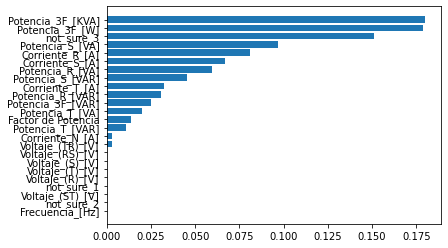

In [ ]:
f_i = list(zip(features,best_random.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

In [ ]:
RSG_train_X_multi=RSG_train_X_multi.loc[:,["Potencia_3F_[W]","not_sure_3","Potencia_3F_[KVA]","Corriente_T_[A]","Potencia_R_[VA]","Potencia_T_[VA]","Corriente_R_[A]","Potencia_S_[VA]","Potencia_T_[VAR]","Corriente_S_[A]"]]
RSG_test_X_multi=RSG_test_X_multi.loc[:,["Potencia_3F_[W]","not_sure_3","Potencia_3F_[KVA]","Corriente_T_[A]","Potencia_R_[VA]","Potencia_T_[VA]","Corriente_R_[A]","Potencia_S_[VA]","Potencia_T_[VAR]","Corriente_S_[A]"]]

In [ ]:
scaler_X_multi=MinMaxScaler()
scaler_Y_multi=MinMaxScaler()
scaler_X_multi.fit(RSG_train_X_multi)
scaler_Y_multi.fit(RSG_train_Y_multi)
scaled_X_train_multi=scaler_X_multi.transform(RSG_train_X_multi)
scaled_X_test_multi=scaler_X_multi.transform(RSG_test_X_multi)
scaled_Y_train_multi=scaler_Y_multi.transform(RSG_train_Y_multi)
scaled_Y_test_multi=scaler_Y_multi.transform(RSG_test_Y_multi)

In [ ]:
train_generator_multi = TimeseriesGenerator(scaled_X_train_multi, scaled_Y_train_multi, length=n_steps, batch_size=100)
test_generator_multi=TimeseriesGenerator(scaled_X_test_multi, scaled_Y_test_multi,length=n_steps,batch_size=100)

In [ ]:
X,y=train_generator_multi[0]


In [ ]:
from keras.layers.recurrent_v2 import LSTM
# define model
n_features=10
model = Sequential()
model.add(LSTM(30, input_shape=(n_steps,n_features),activation='relu',return_sequences=True))
model.add(LSTM(30,activation='relu',return_sequences=False))
model.add(Dense(3, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 30)            4920      
                                                                 
 lstm_1 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 3)                 93        
                                                                 
Total params: 12,333
Trainable params: 12,333
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_generator_multi, epochs=100,validation_data=test_generator_multi)

Epoch 1/100
82/82 [==============================] - 10s 72ms/step - loss: 0.0372 - val_loss: 0.0046
Epoch 2/100
82/82 [==============================] - 8s 103ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 3/100
82/82 [==============================] - 12s 141ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 4/100
82/82 [==============================] - 6s 68ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 5/100
82/82 [==============================] - 6s 67ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/100
82/82 [==============================] - 6s 75ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 7/100
82/82 [==============================] - 5s 67ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/100
82/82 [==============================] - 6s 68ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 9/100
82/82 [==============================] - 6s 68ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 10/100
82/82 [==============================] - 6s 68ms/step - loss: 0.0021 - val_loss: 0.

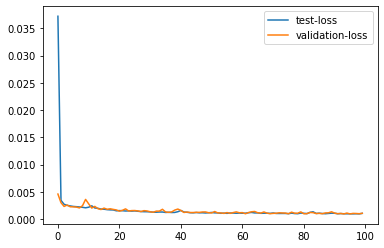

In [ ]:
loss_per_epoch = model.history.history['loss']
loss_vall=model.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch,label="test-loss")
plt.plot(range(len(loss_vall)),loss_vall,label="validation-loss")
plt.legend()

In [ ]:
N=1000
Q=0
L_true_R=  list(RSG_train_Y_multi.iloc[n_steps+1+Q:n_steps+1+Q+N,0])
L_true_S=  list(RSG_train_Y_multi.iloc[n_steps+1+Q:n_steps+1+Q+N,1])
L_true_T=  list(RSG_train_Y_multi.iloc[n_steps+1+Q:n_steps+1+Q+N,2])

In [ ]:
trainPredict = model.predict(train_generator_multi)
testPredict = model.predict(test_generator_multi)

In [ ]:
true_pre_r=scaler_Y_multi.inverse_transform(trainPredict)

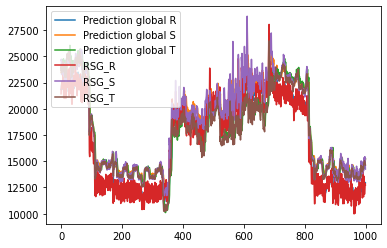

In [ ]:
plt.plot(range(len(L_true_R)),true_pre_r[Q:Q+N,0],label='Prediction global R')
plt.plot(range(len(L_true_R)),true_pre_r[Q:Q+N,1],label='Prediction global S')
plt.plot(range(len(L_true_R)),true_pre_r[Q:Q+N,2],label='Prediction global T')
plt.plot(range(len(L_true_R)),L_true_R,label='RSG_R')
plt.plot(range(len(L_true_S)),L_true_S,label='RSG_S')
plt.plot(range(len(L_true_T)),L_true_T,label='RSG_T')
plt.legend()
plt.show()

In [ ]:
def create_Model(n_input, neurons = 100, layers=3,n_features=9,type_mod="LSTM"):
  # define model
  model = Sequential()
  if(type_mod=="LSTM"):
    if(layers>1):
      model.add(LSTM(neurons, activation='relu', input_shape=(n_input, n_features+1),return_sequences=True))
      for i in range(layers-2):
        model.add(LSTM(neurons, activation='relu',return_sequences=True))
      model.add(LSTM(neurons, activation='relu'))
    else:
      model.add(LSTM(neurons, activation='relu', input_shape=(n_input, n_features+1)))
    model.add(Dense(3))
  if(type_mod=="GRU"):
    if(layers>1):
      model.add(GRU(neurons, activation='relu', input_shape=(n_input, n_features+1),return_sequences=True))
      for i in range(layers-2):
        model.add(GRU(neurons, activation='relu',return_sequences=True))
      model.add(GRU(neurons, activation='relu'))
    else:
      model.add(GRU(neurons, activation='relu', input_shape=(n_input, n_features+1)))
    model.add(Dense(3))
  if(type_mod=="RNN"):
    if(layers>1):
      model.add(SimpleRNN(neurons, activation='relu', input_shape=(n_input, n_features+1),return_sequences=True))
      for i in range(layers-2):
        model.add(SimpleRNN(neurons, activation='relu',return_sequences=True))
      model.add(SimpleRNN(neurons, activation='relu'))
    else:
      model.add(SimpleRNN(neurons, activation='relu', input_shape=(n_input, n_features+1)))
    model.add(Dense(3))

  model.compile(loss='mse', optimizer='adam')
  return model

In [ ]:
precedent_result=[]

In [ ]:
import json

In [ ]:
with open("./drive/MyDrive/DatosInvestigacion/Reccurent_neural_network_result.txt",'r') as fp:
    for line in fp:
      precedent_result.append(json.loads(line))

In [ ]:
df_precedent_result = pd.DataFrame(precedent_result)

In [ ]:
already_happen_combination=[]

In [ ]:
df_result=df_precedent_result

In [ ]:
for i in range(len(df_result)):
  already_happen_combination.append((int(df_result.iloc[i]['N_input']),
                                   int(df_result.iloc[i]['Neurons']),
                                   int(df_result.iloc[i]['Batch size']),
                                   int(df_result.iloc[i]['Number of layer']),
                                   str(df_result.iloc[i]['Type of model'])))

In [ ]:
(18,50,150,3, "LSTM") in already_happen_combination



True

In [ ]:
model_type=["LSTM","RNN","GRU"]
min_RMSE=10000
for mod_typ in model_type:
  for N_input in range(18,28,2): #hasta dos días y medio hacia el pasado
    for num_neurons in range(50,126,25): 
      for batch_size in range(50,201,50):
        for num_layers in range(1,4):
          if((N_input,num_neurons,batch_size,num_layers,mod_typ) in already_happen_combination):
            continue
          print({
              'N_input':N_input,
              'Neurons':num_neurons,
              'Batch size':batch_size,
              'Number of layers': num_layers,
              'Type of model':mod_typ,
          })
          n_input = N_input # horas hacia atrás
          n_output = 3
          n_features = 9 # variables exógenas
          train_generator_multi_2 = TimeseriesGenerator(scaled_X_train_multi, scaled_Y_train_multi, length=N_input, batch_size=batch_size)
          test_generator_multi_2=TimeseriesGenerator(scaled_X_test_multi, scaled_Y_test_multi,length=N_input,batch_size=batch_size)
          X,y=train_generator_multi_2[0]
          model2 = create_Model(N_input,num_neurons,num_layers,n_features,mod_typ)
          model2.fit(train_generator_multi_2, epochs=10,verbose=0)
          predictions = model2.predict(test_generator_multi_2)
          true_predictions=scaler_Y_multi.inverse_transform(predictions)  
          true_values = df_test.iloc[n_input:][["Potencia_R_[W]","Potencia_S_[W]","Potencia_T_[W]"]]

          errorMSE = mean_squared_error(true_values,true_predictions)
          errorMAE = mean_absolute_error(true_values,true_predictions)
          errorRMSE = np.sqrt(errorMSE)
          if(errorRMSE<min_RMSE):
            print('BEST')
            model.save('./drive/MyDrive/DatosInvestigacion/Reccurent_neural_network_result.h5')
            min_RMSE = errorRMSE

          print('RMSE:',errorRMSE)
          print('MAE',errorMAE)
          print('min RMSE',min_RMSE)
          resultado = {
            'N_input':N_input,
            'Neurons':num_neurons,
            'Batch size':batch_size,
            'Number of layer': num_layers,
            'Type of model':mod_typ,
            'MSE':errorMSE,
            'MAE':errorMAE,
            'RMSE':errorRMSE
        }
          with open("./drive/MyDrive/DatosInvestigacion/Reccurent_neural_network_result.txt","a") as file:
            resultado = json.dumps(resultado)
            file.write(resultado)
            file.write('\n')

{'N_input': 22, 'Neurons': 75, 'Batch size': 200, 'Number of layers': 3, 'Type of model': 'GRU'}
BEST
RMSE: 1186.856641068258
MAE 929.3575165234319
min RMSE 1186.856641068258
{'N_input': 22, 'Neurons': 100, 'Batch size': 50, 'Number of layers': 1, 'Type of model': 'GRU'}
BEST
RMSE: 994.6997990326586
MAE 771.4680420517087
min RMSE 994.6997990326586
{'N_input': 22, 'Neurons': 100, 'Batch size': 50, 'Number of layers': 2, 'Type of model': 'GRU'}
RMSE: 1181.3707799253898
MAE 914.5219102114401
min RMSE 994.6997990326586
{'N_input': 22, 'Neurons': 100, 'Batch size': 50, 'Number of layers': 3, 'Type of model': 'GRU'}
RMSE: 1138.5654997204097
MAE 883.8174306937439
min RMSE 994.6997990326586
{'N_input': 22, 'Neurons': 100, 'Batch size': 100, 'Number of layers': 1, 'Type of model': 'GRU'}
RMSE: 1159.1345092751717
MAE 910.2308702659105
min RMSE 994.6997990326586
{'N_input': 22, 'Neurons': 100, 'Batch size': 100, 'Number of layers': 2, 'Type of model': 'GRU'}
RMSE: 1149.3746517445004
MAE 876.68398

In [ ]:
precedent_result1=[]

In [ ]:
with open("./drive/MyDrive/DatosInvestigacion/Reccurent_neural_network_result.txt",'r') as fp:
    for line in fp:
      precedent_result1.append(json.loads(line))

In [ ]:
df_result = pd.DataFrame(precedent_result1)

In [ ]:
best_param_s=df_result[df_result['RMSE']==df_result['RMSE'].min()]
best_param2=df_result[df_result['MAE']==df_result['MAE'].min()]
print(best_param_s)

     N_input  Neurons  Batch size  Number of layer Type of model  \
276       18      125          50                1           RNN   

               MSE         MAE        RMSE  
276  668801.793758  570.670605  817.803029  


In [ ]:
df_result.head(-1)

,N_input,Neurons,Batch size,Number of layer,Type of model,MSE,MAE,RMSE
0,18,50,50,1,LSTM,1.273778e+06,877.160538,1128.617818
1,18,50,50,2,LSTM,1.078209e+06,766.257324,1038.368659
2,18,50,50,3,LSTM,1.978462e+06,1065.955094,1406.578098
3,18,50,100,1,LSTM,1.634014e+06,989.666705,1278.285618
4,18,50,100,2,LSTM,1.440096e+06,901.067377,1200.040122
...,...,...,...,...,...,...,...,...
714,26,125,150,1,GRU,1.160062e+06,834.943551,1077.061769
715,26,125,150,2,GRU,1.233697e+06,838.704173,1110.719188
716,26,125,150,3,GRU,1.316853e+06,887.703539,1147.542344
717,26,125,200,1,GRU,1.298134e+06,884.811964,1139.356662
